# Preprocessing and Modelling

In this notebook, I import the cleaned dataset and preprocess features to make it suitable for regression.

Contents:
- [Imports](#Imports)
- [Encode nominal categorical variables](#One-Hot-Encoding-for-Nominal-Categorical-Variables)
- [Encode ordinal categorical variables](#Assign-Ratings-for-Ordinal-Categorical-Variables)
- [Consistency checks between train and test data](#Consistency-between-Train-and-Test-Data)
- [Identify distributions of variables and correlation with Sale Price](#Identify-distributions-of-variables-and-correlation-with-Sale-Price)
- [Apply box-cox transformation](#Apply-Box-Cox-Transformation)
- [Fit and Cross Validation of Models](#Fit-and-Cross-Validation-of-Models)
- [Model Evaluation on Kaggle Test Set](#Model-Evaluation-on-Kaggle-Test-Set)
- [References](#References)

### Imports

In [1083]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
# for preprocessing
from scipy.special import boxcox1p, inv_boxcox1p
#for modelling
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

In [1084]:
#read clean dataset
train = pd.read_csv("../data/train_clean.csv")
test = pd.read_csv("../data/test_clean.csv")

In [1085]:
print(train.shape)
print(test.shape)

(2049, 23)
(879, 22)


### One Hot Encoding for Nominal Categorical Variables
For nominal features, I use pandas' get_dummies function to get the dummy variables for each categories.

In [1086]:
#get dummies for nominal features
nom_features = ['ms_zoning','garage_type','neighborhood','condition_2','central_air','sale_type','roof_matl']
train = pd.get_dummies(train, columns = nom_features)
test = pd.get_dummies(test, columns = nom_features)
#check
train.head()

,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,heating_qc,electrical,kitchen_qual,totrms_abvgrd,functional,garage_finish,...,sale_type_ConLI,sale_type_ConLw,sale_type_New,sale_type_Oth,sale_type_WD,roof_matl_CompShg,roof_matl_Membran,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl
0,6,289.0,4,3,Ex,SBrkr,Gd,6,Typ,RFn,...,0,0,0,0,1,1,0,0,0,0
1,7,132.0,4,4,Ex,SBrkr,Gd,8,Typ,RFn,...,0,0,0,0,1,1,0,0,0,0
2,5,0.0,3,3,TA,SBrkr,Gd,5,Typ,Unf,...,0,0,0,0,1,1,0,0,0,0
3,5,0.0,3,4,Gd,SBrkr,TA,7,Typ,Fin,...,0,0,0,0,1,1,0,0,0,0
4,6,0.0,3,2,TA,SBrkr,TA,6,Typ,Unf,...,0,0,0,0,1,1,0,0,0,0


In [1087]:
#check
test.head()

,overall_qual,mas_vnr_area,exter_qual,bsmt_qual,heating_qc,electrical,kitchen_qual,totrms_abvgrd,functional,garage_finish,...,sale_type_New,sale_type_Oth,sale_type_VWD,sale_type_WD,roof_matl_CompShg,roof_matl_Metal,roof_matl_Roll,roof_matl_Tar&Grv,roof_matl_WdShake,roof_matl_WdShngl
0,6,0.0,3,2,Gd,FuseP,Fa,9,Typ,Unf,...,0,0,0,1,1,0,0,0,0,0
1,5,0.0,3,4,TA,SBrkr,TA,10,Typ,Fin,...,0,0,0,1,1,0,0,0,0,0
2,7,0.0,4,4,Ex,SBrkr,Gd,7,Typ,RFn,...,1,0,0,0,1,0,0,0,0,0
3,5,0.0,4,3,TA,SBrkr,TA,5,Typ,Unf,...,0,0,0,1,1,0,0,0,0,0
4,6,247.0,3,4,Gd,SBrkr,TA,6,Typ,RFn,...,0,0,0,1,1,0,0,0,0,0


### Assign Ratings for Ordinal Categorical Variables
For ordinal features, I map integer ratings.

In [1088]:
#assign integer ratings to ordinal features
train['heating_qc'] = train['heating_qc'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
train['electrical'] = train['electrical'].map({'SBrkr':5, 'FuseF':3, 'FuseA':4,'FuseP':2,'Mix':1})
train['kitchen_qual'] = train['kitchen_qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2})
train['functional'] = train['functional'].map({'Typ':7, 'Mod':5, 'Min2':5, 'Maj1':4,'Min1':6,'Sev':2,'Sal':1,'Maj2':3})
train['garage_finish'] = train['garage_finish'].map({'RFn':2,'Unf':1,'Fin':3,'None':0})
train['paved_drive'] = train['paved_drive'].map({'Y':3,'N':1,'P':2})

test['heating_qc'] = test['heating_qc'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
test['electrical'] = test['electrical'].map({'SBrkr':5, 'FuseF':3, 'FuseA':4,'FuseP':2,'Mix':1})
test['kitchen_qual'] = test['kitchen_qual'].map({'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1})
test['functional'] = test['functional'].map({'Typ':7, 'Mod':5, 'Min2':5, 'Maj1':4,'Min1':6,'Sev':2,'Sal':1,'Maj2':3})
test['garage_finish'] = test['garage_finish'].map({'RFn':2,'Unf':1,'Fin':3,'None':0})
test['paved_drive'] = test['paved_drive'].map({'Y':3,'N':1,'P':2})

### Consistency between Train and Test Data
As part of kaggle requirements, the test data and train data must have the same number of rows, and to prepare for modelling, the test set must have the same columns as the train set in the correct order. 

In [1089]:
#find out what columns are missing in the test set
missing_col_from_test = [col for col in train.columns if col not in test.columns]
#remove saleprice
missing_col_from_test = missing_col_from_test[1:]
missing_col_from_test

['ms_zoning_A (agr)',
 'neighborhood_GrnHill',
 'neighborhood_Landmrk',
 'condition_2_Artery',
 'condition_2_RRAe',
 'condition_2_RRAn',
 'condition_2_RRNn',
 'roof_matl_Membran']

In [1090]:
#add these in and impute with 0
for col in missing_col_from_test:
    test[col] = 0
#drop these missing columns from train set 
# train.drop(missing_col_from_test, axis = 1, inplace = True)

In [1091]:
#check
print(train.shape)
print(test.shape)

(2049, 82)
(879, 84)


In [1092]:
#find out what is missing in train set
missing_col_from_train = [col for col in test.columns if col not in train.columns]
missing_col_from_train

['sale_type_VWD', 'roof_matl_Metal', 'roof_matl_Roll']

In [1093]:
#drop these columns from test set 
test.drop(missing_col_from_train, axis = 1, inplace = True)

In [1094]:
[col for col in test.columns if col not in train.columns]

[]

In [1095]:
[col for col in train.columns if col not in test.columns]

['saleprice']

In [1096]:
#make sure it's the same order
test = test.reindex(train.columns, axis = 1)

In [1097]:
test.drop(columns=['saleprice'],inplace = True)

In [1098]:
print(train.shape)
print(test.shape)

(2049, 82)
(879, 81)


In [1099]:
#rearrange and put saleprice at the back
saleprice = train[['saleprice']]
train.drop(['saleprice'],axis = 1, inplace = True)
train = pd.concat([train,saleprice], axis = 1)

### Identify distributions of variables and correlation with Sale Price

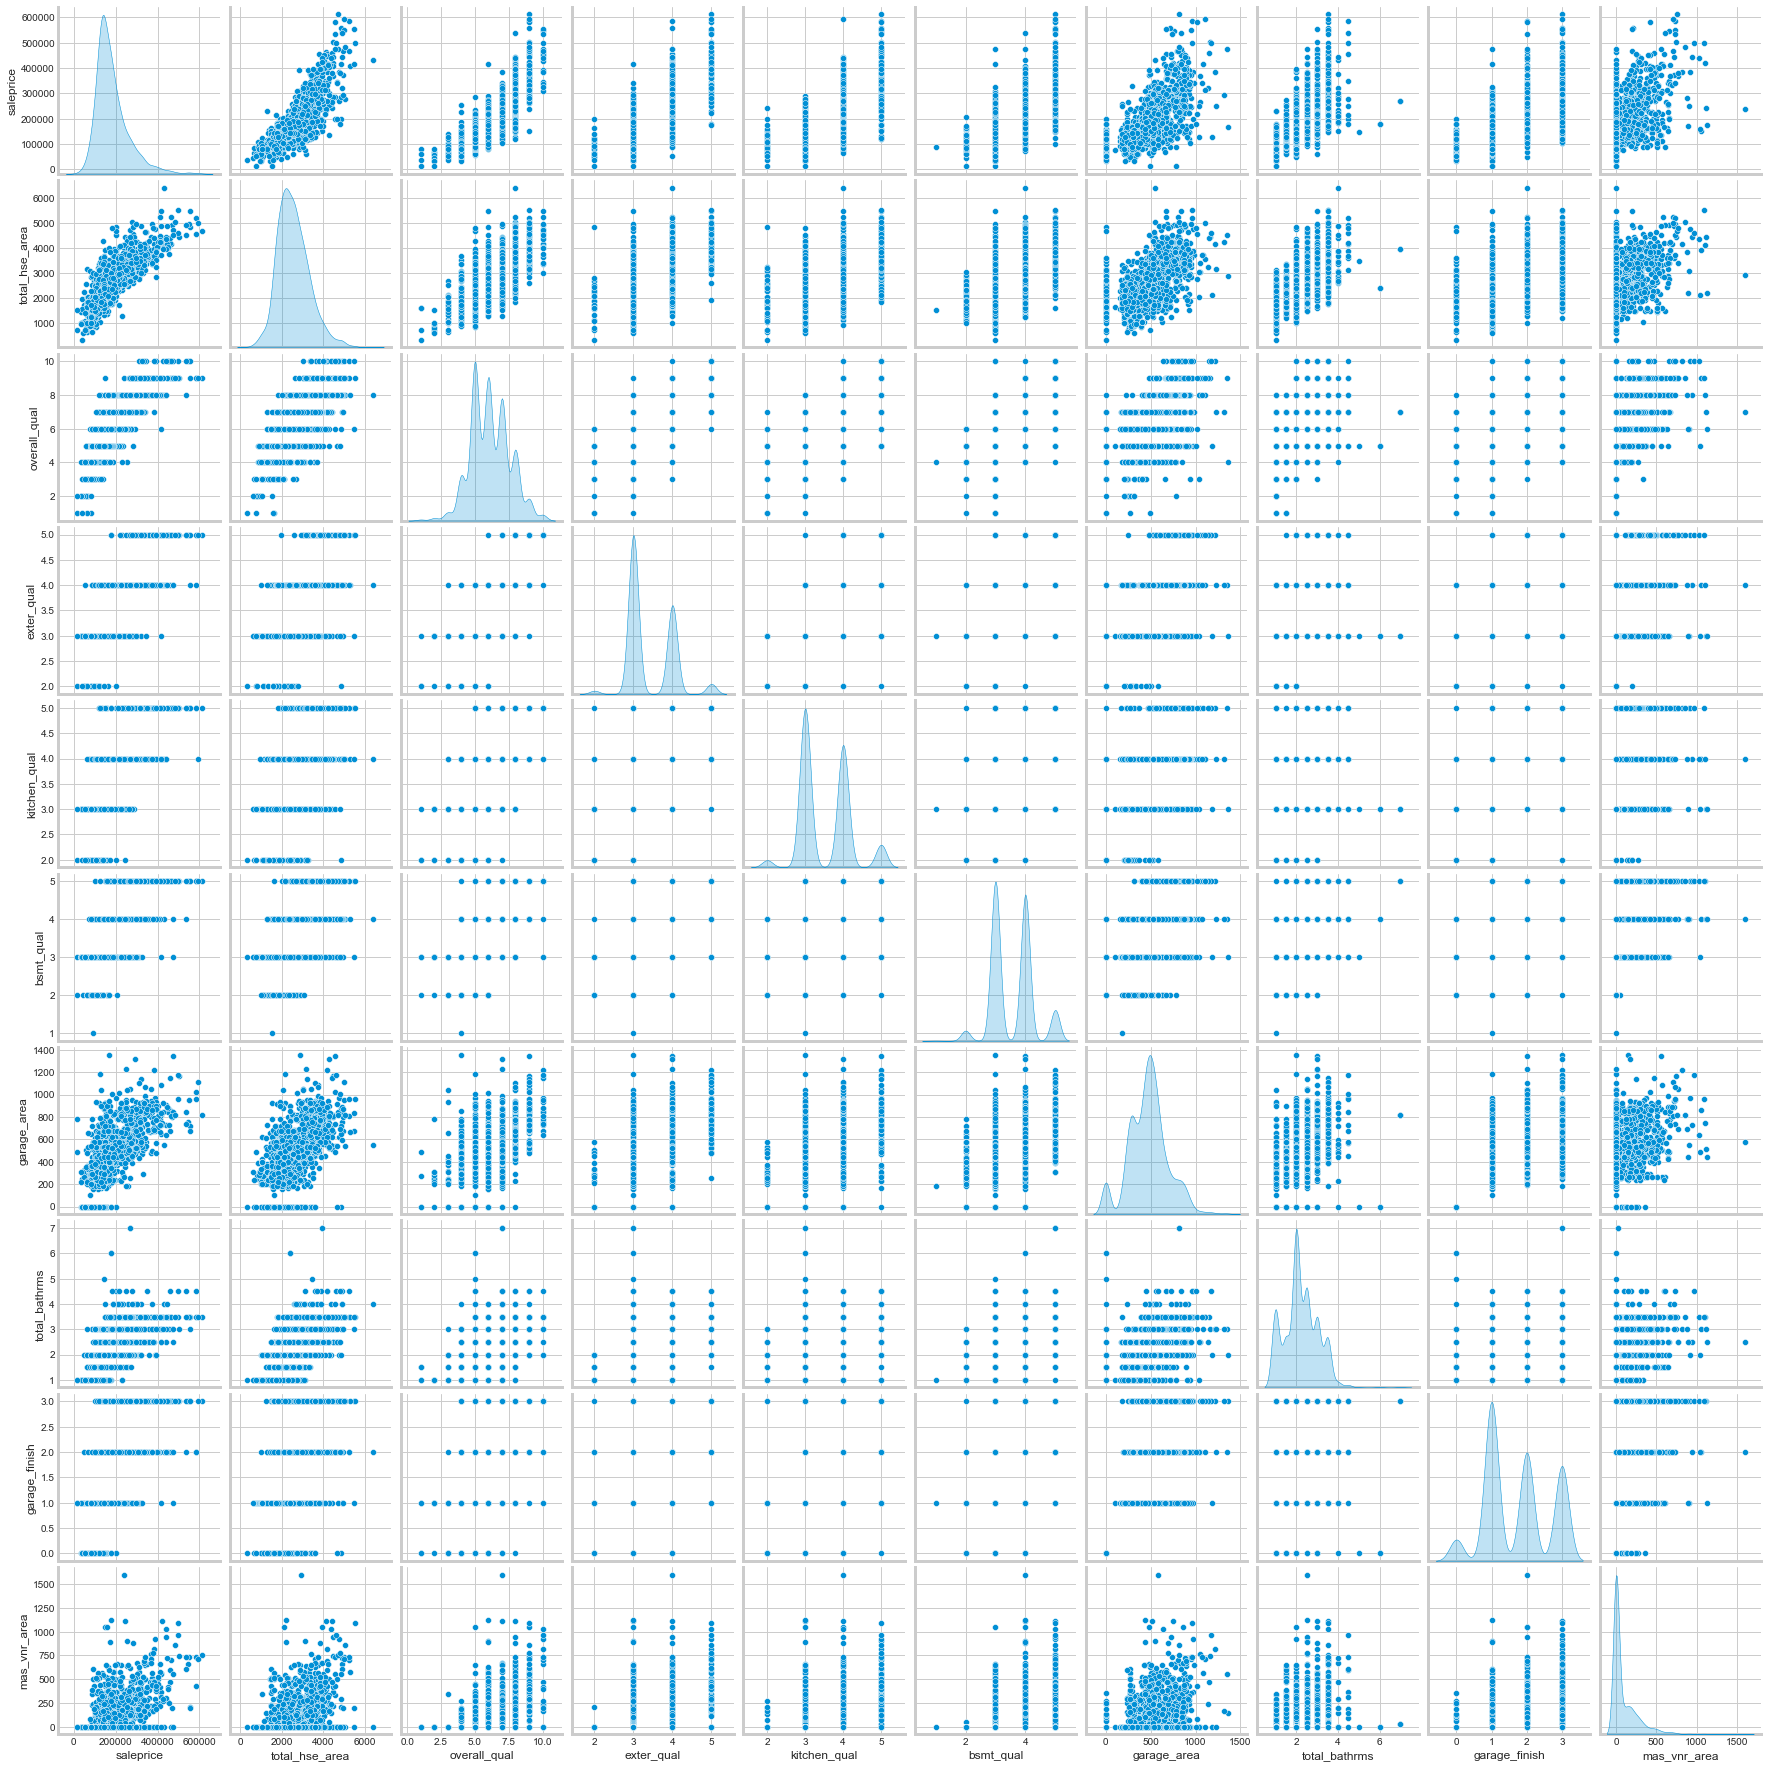

In [1100]:
# look at the top 10 strongest correlation with saleprice
sns.pairplot(train[train.corr().nlargest(10,'saleprice').index], kind = 'scatter', diag_kind = 'kde');

There are some skewed distributions which should be transformed. From here, we also note that features garage area and total house area which have strong correlation with sale price and is therefore, probably very important factors affecting house prices.

array([[<AxesSubplot:title={'center':'overall_qual'}>,
        <AxesSubplot:title={'center':'mas_vnr_area'}>,
        <AxesSubplot:title={'center':'exter_qual'}>,
        <AxesSubplot:title={'center':'bsmt_qual'}>,
        <AxesSubplot:title={'center':'heating_qc'}>,
        <AxesSubplot:title={'center':'electrical'}>,
        <AxesSubplot:title={'center':'kitchen_qual'}>,
        <AxesSubplot:title={'center':'totrms_abvgrd'}>,
        <AxesSubplot:title={'center':'functional'}>],
       [<AxesSubplot:title={'center':'garage_finish'}>,
        <AxesSubplot:title={'center':'garage_area'}>,
        <AxesSubplot:title={'center':'paved_drive'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'total_hse_area'}>,
        <AxesSubplot:title={'center':'total_bathrms'}>,
        <AxesSubplot:title={'center':'ms_zoning_A (agr)'}>,
        <AxesSubplot:title={'center':'ms_zoning_C (all)'}>,
        <AxesSubplot:title={'center':'ms_zoning_FV'}>],
       [<AxesSu

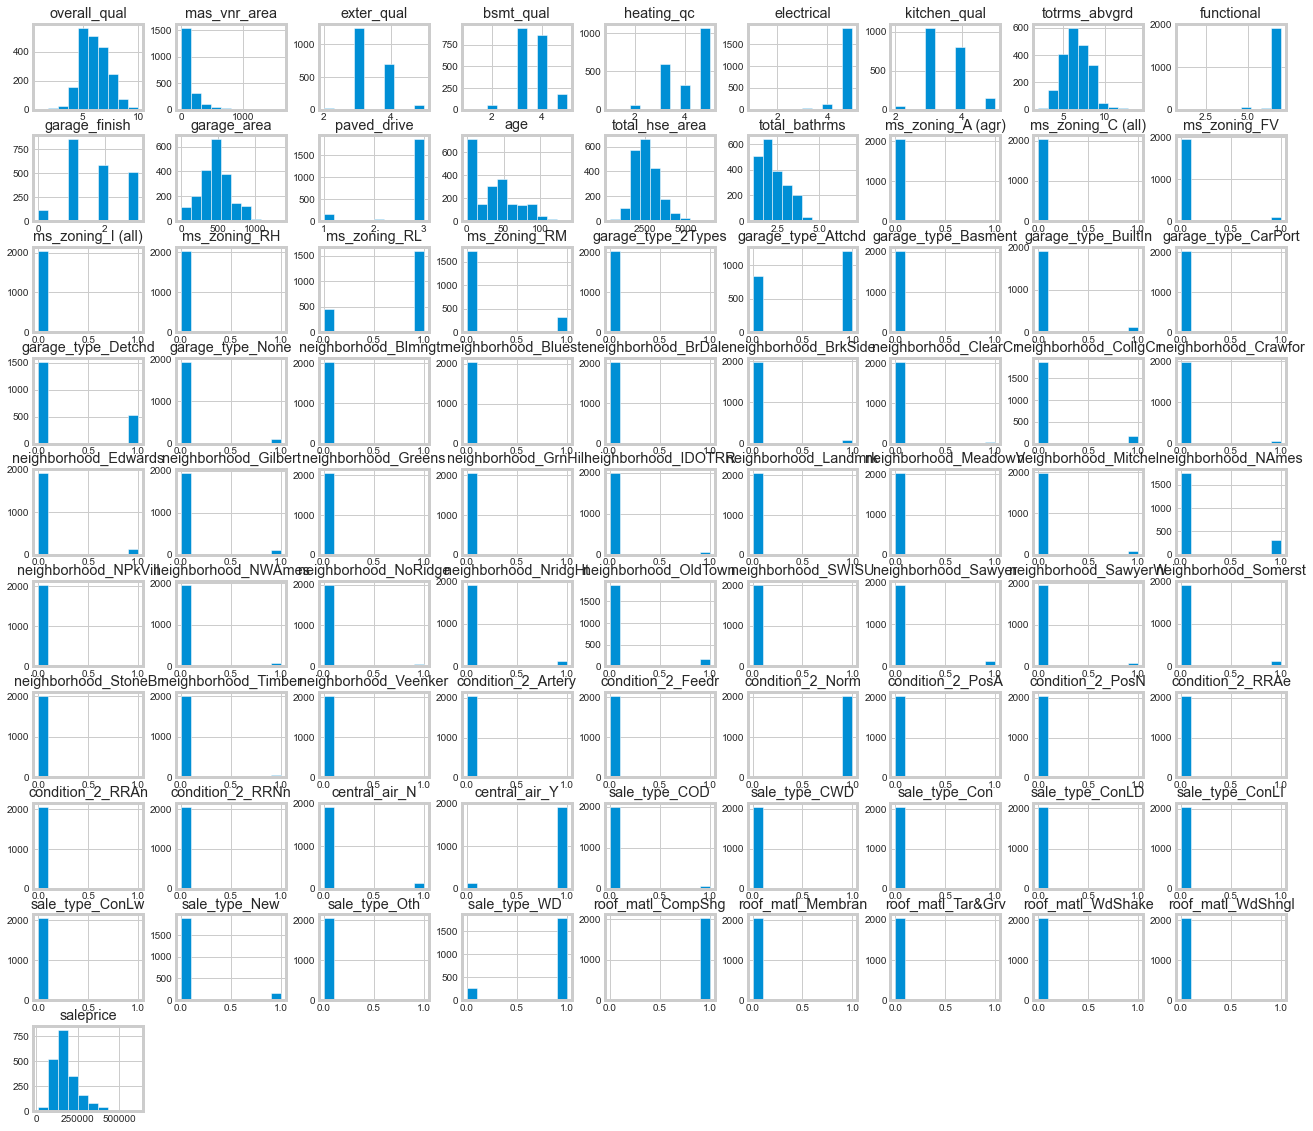

In [1101]:
#identify skewed distributions and transform
train.hist(figsize = (20,20))

### Apply Box-Cox Transformation
I apply box cos transformation for skewed distributions.

In [1102]:
skewed_columns = ['overall_qual','mas_vnr_area','age','saleprice', 'total_bathrms', 'total_hse_area']
skewed_columns_less_saleprice = [col for col in skewed_columns if col != 'saleprice']
for col in skewed_columns_less_saleprice:
    train[col] = boxcox1p(train[col],0.15) #boxcox1p to take into account zeros
    test[col] = boxcox1p(test[col],0.15)
    
train['saleprice'] = boxcox1p(train['saleprice'],0.15)

array([[<AxesSubplot:title={'center':'overall_qual'}>,
        <AxesSubplot:title={'center':'mas_vnr_area'}>,
        <AxesSubplot:title={'center':'exter_qual'}>,
        <AxesSubplot:title={'center':'bsmt_qual'}>,
        <AxesSubplot:title={'center':'heating_qc'}>,
        <AxesSubplot:title={'center':'electrical'}>,
        <AxesSubplot:title={'center':'kitchen_qual'}>,
        <AxesSubplot:title={'center':'totrms_abvgrd'}>,
        <AxesSubplot:title={'center':'functional'}>],
       [<AxesSubplot:title={'center':'garage_finish'}>,
        <AxesSubplot:title={'center':'garage_area'}>,
        <AxesSubplot:title={'center':'paved_drive'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'total_hse_area'}>,
        <AxesSubplot:title={'center':'total_bathrms'}>,
        <AxesSubplot:title={'center':'ms_zoning_A (agr)'}>,
        <AxesSubplot:title={'center':'ms_zoning_C (all)'}>,
        <AxesSubplot:title={'center':'ms_zoning_FV'}>],
       [<AxesSu

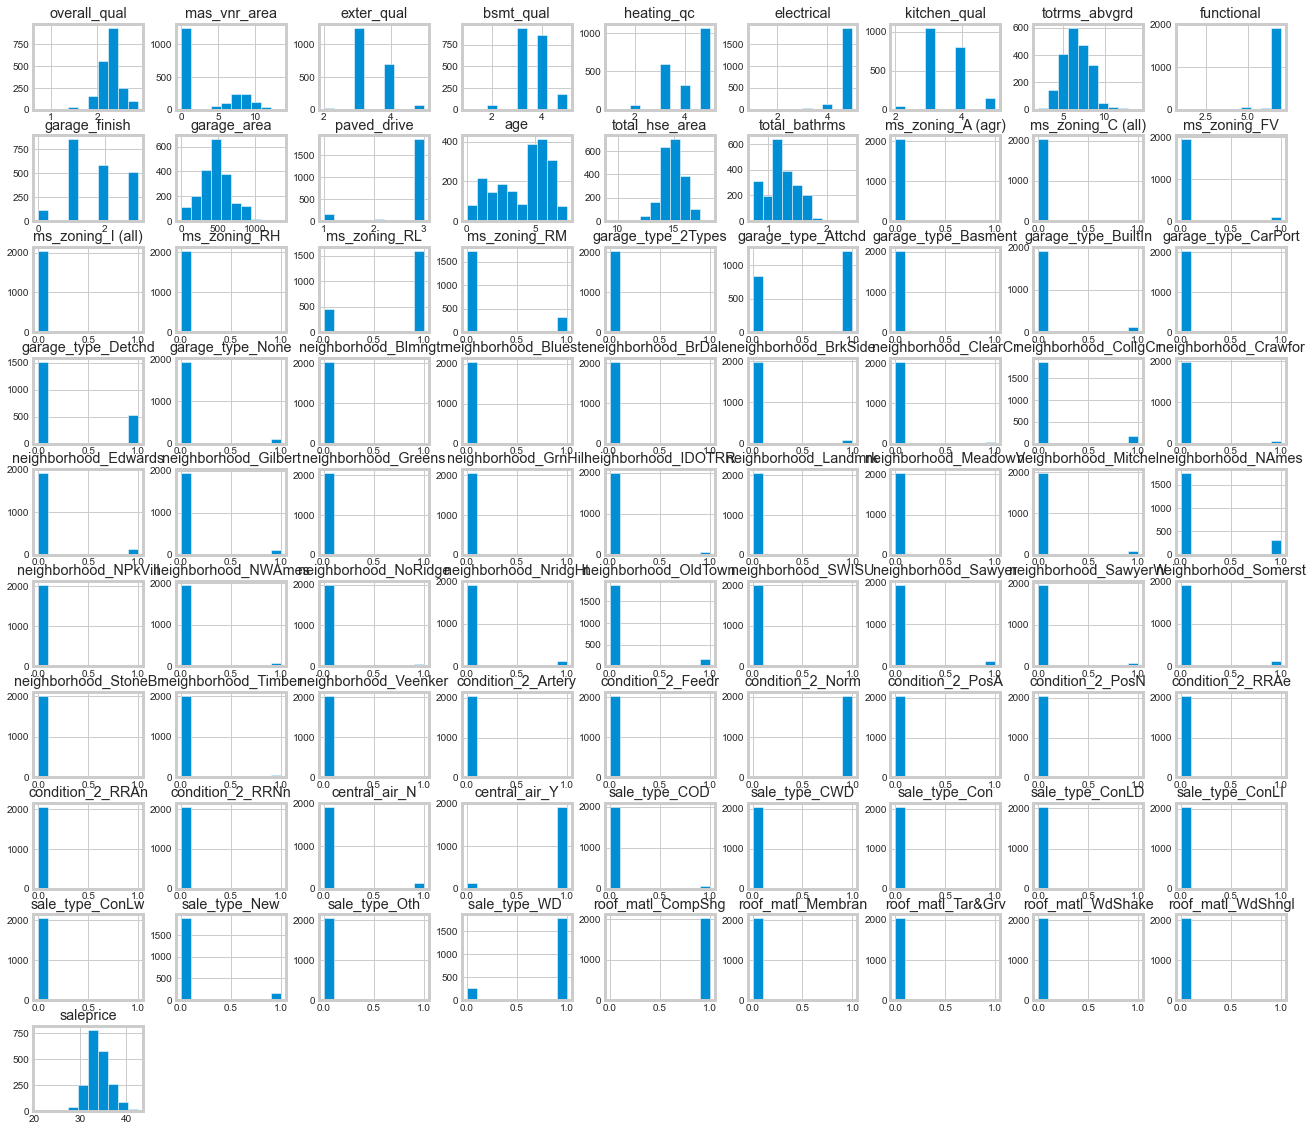

In [1103]:
train.hist(figsize = (20,20))

In [1104]:
# save processed data to csv
train.to_csv("../data/train_processed.csv", index = False)
test.to_csv("../data/test_processed.csv", index = False)

## Exploratory Modelling

In [1105]:
# create features and target variable into X and y
features = [col for col in train.columns if col != 'saleprice']
X = train[features]
y = train['saleprice']

In [1106]:
# do the train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [1107]:
# scaling
ss = StandardScaler()
ss.fit(X_train)
X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

### Fit and Cross Validation of Models
I apply the Linear Regression Model, Ridge Model, Lasso Model and ElasticNet Model. Cross validation will be done with kfolds = 10 as this is generally optimal (Brownlee, 2020).

In [1108]:
#instantiate models
lr = LinearRegression()
ridge = RidgeCV(alphas = np.linspace(0.1, 10, 100))
lasso = LassoCV(n_alphas = 200)
enet = ElasticNetCV(l1_ratio = np.linspace(0.001, 1, 50), n_alphas = 100)

#### Linear Regression

In [1109]:
#fit
lr.fit(X_train_ss,y_train)
#cross validation using 10 folds - lr
lr_negmse_score = cross_val_score(lr, X_train_ss, y_train, cv = 10, scoring = 'neg_mean_squared_error')
lr_mse_score = -lr_negmse_score
lr_rmse_score = np.sqrt(lr_mse_score)
print("RMSE (Train): ", lr_rmse_score.mean()) 
lr_r2_score = cross_val_score(lr, X_train_ss, y_train, cv = 10)
print("R2 score (Train): ", lr_r2_score.mean())

RMSE (Train):  26104940455.075928
R2 score (Train):  -6.51346456150934e+20


In [1110]:
# find features with highest coefficients
lr_features = pd.DataFrame(X.columns, columns=['feature'])
lr_features['coef'] = lr.coef_
lr_features['abs_coef'] = np.abs(lr.coef_)
lr_features.sort_values(by='abs_coef', ascending=False).head(10)

,feature,coef,abs_coef
75,sale_type_WD,-2.188829e+12,2.188829e+12
73,sale_type_New,-1.724795e+12,1.724795e+12
76,roof_matl_CompShg,1.316080e+12,1.316080e+12
67,sale_type_COD,-1.171324e+12,1.171324e+12
78,roof_matl_Tar&Grv,1.029841e+12,1.029841e+12
23,garage_type_Attchd,9.091632e+11,9.091632e+11
27,garage_type_Detchd,8.167153e+11,8.167153e+11
70,sale_type_ConLD,-5.933076e+11,5.933076e+11
80,roof_matl_WdShngl,5.522785e+11,5.522785e+11
79,roof_matl_WdShake,5.522785e+11,5.522785e+11


In [1111]:
#apply on test set 
lr_test_r2_score = lr.score(X_test_ss,y_test)
print("R2 score (Test): ", lr_test_r2_score.mean())

R2 score (Test):  -5.902321224743555e+21


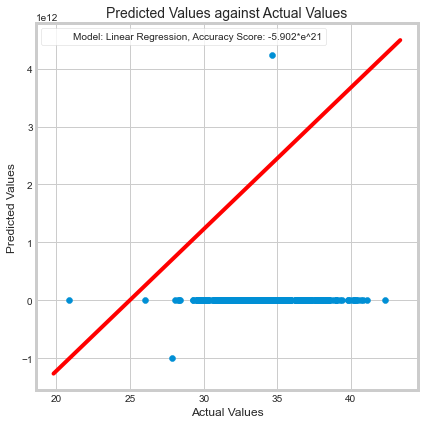

In [1151]:
# predicted against actual house prices plot
ypred = lr.predict(X_test_ss)
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(y_test, ypred)
ax.set_title('Predicted Values against Actual Values',fontsize=14)
ax.set_xlabel('Actual Values',fontsize=12)
ax.set_ylabel('Predicted Values',fontsize=12)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.plot([], [], ' ', label="Model: Linear Regression, Accuracy Score: -5.902*e^21")
plt.legend()
plt.tight_layout()

Visually it is pretty obvious that linear regression is not a good model for predicting house prices. The actual and predicted values do not come close to the red horizontal line. 

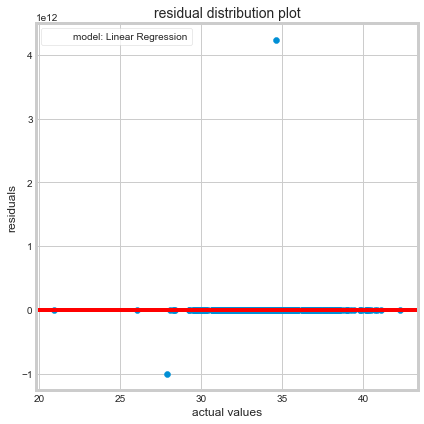

In [1117]:
# residual plot
residuals = ypred - y_test
plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(y_test, residuals)
plt.axhline(0, linestyle='-', color='r')
plt.title('Residual Distribution Plot',fontsize=14)
plt.xlabel('Actual Values',fontsize=12)
plt.ylabel('Residuals',fontsize=12)
plt.plot([], [], ' ', label="model: Linear Regression")
plt.legend()
plt.tight_layout()

From residual plots, we want to ensure that there is a consistent random error (Frost, 2020). Visually we want to see points scattered around with no clear trend or bias. In this case, we see that the error is consistent with horizontal red line, which means that this is definitely not a good model to work with. 

#### Ridge Model

In [1119]:
#fit
ridge.fit(X_train_ss, y_train)
#cross validation using 10 folds 
ridge_negmse_scores = cross_val_score(ridge, X_train_ss, y_train, cv = 10, scoring = 'neg_mean_squared_error')
ridge_mse_score = -ridge_negmse_scores
ridge_rmse_scores = np.sqrt(ridge_mse_score)
print("RMSE: ",ridge_rmse_scores.mean())
ridge_r2_score = cross_val_score(ridge, X_train_ss, y_train, cv = 10)
print("R2 score: ", ridge_r2_score.mean())

RMSE:  0.8367695507849179
R2 score:  0.8849762259551326


In [1120]:
# find features with highest coefficients
ridge_features = pd.DataFrame(X.columns, columns=['feature'])
ridge_features['coef'] = ridge.coef_
ridge_features['abs_coef'] = np.abs(ridge.coef_)
ridge_features.sort_values(by='abs_coef', ascending=False).head(15)

,feature,coef,abs_coef
13,total_hse_area,0.737711,0.737711
0,overall_qual,0.404776,0.404776
10,garage_area,0.291791,0.291791
14,total_bathrms,0.255089,0.255089
6,kitchen_qual,0.227330,0.227330
3,bsmt_qual,0.209650,0.209650
35,neighborhood_Crawfor,0.159345,0.159345
2,exter_qual,0.139914,0.139914
7,totrms_abvgrd,0.139731,0.139731
8,functional,0.123765,0.123765


In [1121]:
#apply on test set 
ridge_test_r2_score = ridge.score(X_test_ss,y_test)
print("R2 score (Test): ", ridge_test_r2_score.mean())

R2 score (Test):  0.8751689750951371


While the R2 score for ridge model is good (0.885), it did not generalise well as seen in the drop in accuracy of the R2 score on the validation set (0.875). 

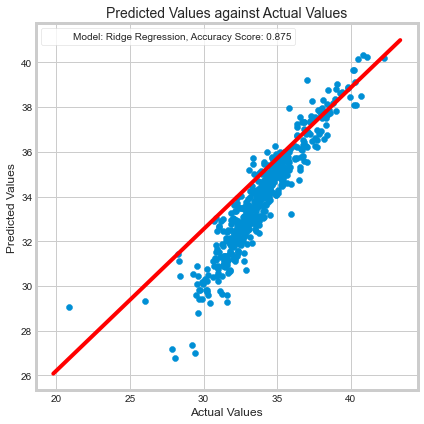

In [1147]:
# predicted against actual house prices plot
ypred = ridge.predict(X_test_ss)
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(y_test, ypred)
ax.set_title('Predicted Values against Actual Values',fontsize=14)
ax.set_xlabel('Actual Values',fontsize=12)
ax.set_ylabel('Predicted Values',fontsize=12)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.plot([], [], ' ', label="Model: Ridge Regression, Accuracy Score: 0.875")
plt.legend()
plt.tight_layout()

Ridge model is much closer to predicting house prices. As we can see the blue scatter points getting pretty close to the red line. This means that this model is able to account for 87.5% of variability in data. 

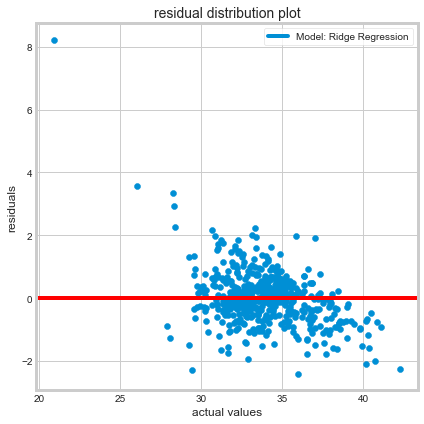

In [1146]:
# residual plot
residuals = ypred - y_test
plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(y_test, residuals)
plt.axhline(0, linestyle='-', color='r')
plt.title('residual distribution plot',fontsize=14)
plt.xlabel('actual values',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.plot([], [], '', label="Model: Ridge Regression")
plt.legend()
plt.tight_layout()

From the residual plot, we see that points are concentrated around zero, which is a good sign and there is no clear trend in the scatter (ie. errors are random). This suggests that the model is a pretty good fit. 

#### Lasso Model

In [1127]:
#fit
lasso.fit(X_train_ss, y_train)
#cross validation using 10 folds - lasso
lasso_negmse_scores = cross_val_score(lasso, X_train_ss, y_train, cv = 10, scoring = 'neg_mean_squared_error')
lasso_mse_score = -lasso_negmse_scores
lasso_rmse_scores = np.sqrt(lasso_mse_score)
print("RMSE (Train): ",lasso_rmse_scores.mean())
lasso_r2_score = cross_val_score(lasso, X_train_ss, y_train, cv = 10)
print("R2 score (Train): ", lasso_r2_score.mean())

RMSE (Train):  0.8327849036652587
R2 score (Train):  0.8862047282505248


In [1128]:
# find features with highest coefficients from lasso
lasso_features = pd.DataFrame(X.columns, columns=['feature'])
lasso_features['coef'] = lasso.coef_
lasso_features['abs_coef'] = np.abs(lasso.coef_)
lasso_features.sort_values(by='abs_coef', ascending=False).head(10)

,feature,coef,abs_coef
13,total_hse_area,0.786174,0.786174
0,overall_qual,0.436595,0.436595
10,garage_area,0.277430,0.277430
14,total_bathrms,0.240537,0.240537
6,kitchen_qual,0.229045,0.229045
3,bsmt_qual,0.187127,0.187127
35,neighborhood_Crawfor,0.150093,0.150093
2,exter_qual,0.131265,0.131265
7,totrms_abvgrd,0.108842,0.108842
8,functional,0.106227,0.106227


In [1129]:
#apply on test set 
lasso_test_r2_score = lasso.score(X_test_ss,y_test)
print("R2 score (Test): ", lasso_test_r2_score.mean())

R2 score (Test):  0.8776264760054415


While the R2 score for lasso model is slightly better than ridge (0.886), it also did not generalise well as seen in the drop in accuracy of the R2 score on the validation set (0.878). 

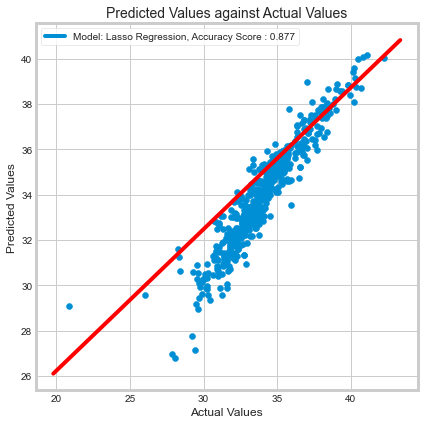

In [1148]:
# predicted against actual house prices plot
ypred = lasso.predict(X_test_ss)
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(y_test, ypred)
ax.set_title('Predicted Values against Actual Values',fontsize=14)
ax.set_xlabel('Actual Values',fontsize=12)
ax.set_ylabel('Predicted Values',fontsize=12)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.plot([], [], '', label="Model: Lasso Regression, Accuracy Score : 0.877")
plt.legend()
plt.tight_layout()

Looking at predicted against actual values under Lasso Model, the blue scatter points are also very close to the red line indicating a relatively good fit. Looking at the R2 score, we see that Lasso Model performed slightly better in Ridge Model in that the former is able to account for greater variability of data at 87.7% compared to Ridge at 87.5%.

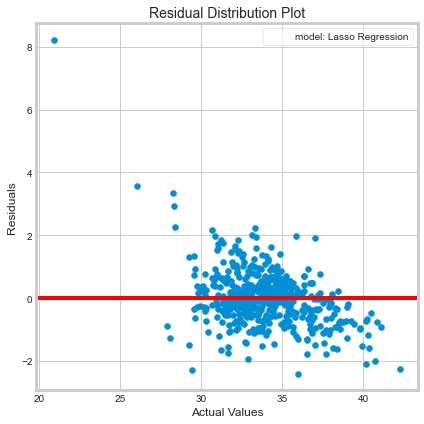

In [1134]:
# residual plot
residuals = ypred - y_test
plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(y_test, residuals)
plt.axhline(0, linestyle='-', color='r')
plt.title('Residual Distribution Plot',fontsize=14)
plt.xlabel('Actual Values',fontsize=12)
plt.ylabel('Residuals',fontsize=12)
plt.plot([], [], ' ', label="model: Lasso Regression")
plt.legend()
plt.tight_layout()

We also see a random residual scatter which is a good sign that this model is a good fit. 

#### Enet Model

In [1136]:
#fit
enet.fit(X_train_ss, y_train)
#cross validation using 10 folds - enet
enet_scores = cross_val_score(enet, X_train_ss, y_train, cv = 10, scoring = 'neg_mean_squared_error')
enet_mse_score = -enet_scores
enet_rmse_scores = np.sqrt(enet_mse_score)
print("RMSE (Train): ",enet_rmse_scores.mean())
enet_r2_score = cross_val_score(enet, X_train_ss, y_train, cv = 10)
print("R2 score (Train): ", enet_r2_score.mean())

RMSE (Train):  0.8307639012401362
R2 score (Train):  0.886728072105773


In [1137]:
# find features with highest coefficients from enet
enet_features = pd.DataFrame(X.columns, columns=['feature'])
enet_features['coef'] = enet.coef_
enet_features['abs_coef'] = np.abs(enet.coef_)
enet_features.sort_values(by='abs_coef', ascending=False).head(10)

,feature,coef,abs_coef
13,total_hse_area,0.674344,0.674344
0,overall_qual,0.404826,0.404826
10,garage_area,0.270581,0.270581
14,total_bathrms,0.250685,0.250685
6,kitchen_qual,0.226414,0.226414
3,bsmt_qual,0.192548,0.192548
7,totrms_abvgrd,0.162047,0.162047
35,neighborhood_Crawfor,0.152746,0.152746
2,exter_qual,0.147948,0.147948
48,neighborhood_NridgHt,0.113910,0.113910


In [1138]:
#apply on test set 
enet_test_r2_score = enet.score(X_test_ss,y_test)
print("R2 score (Test): ", enet_test_r2_score.mean())

R2 score (Test):  0.876979845922186


Enet model performance did relatively similar to Lasso, with R2 score (0.887) on train set but also lower accuracy on the test set with R2 score (0.877)

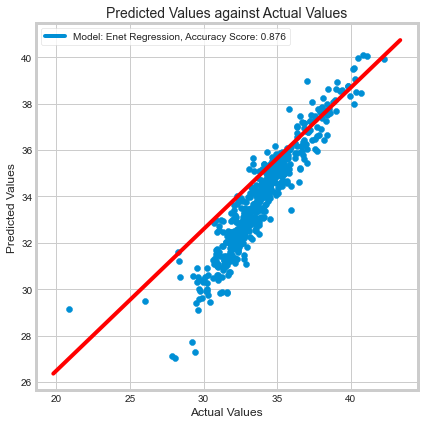

In [1149]:
# predicted against actual house prices plot
ypred = enet.predict(X_test_ss)
fig, ax = plt.subplots(figsize = (6,6))
ax.scatter(y_test, ypred)
ax.set_title('Predicted Values against Actual Values',fontsize=14)
ax.set_xlabel('Actual Values',fontsize=12)
ax.set_ylabel('Predicted Values',fontsize=12)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="-", c="r")
plt.plot([], [], '', label="Model: Enet Regression, Accuracy Score: 0.876")
plt.legend()
plt.tight_layout()

We expect a similar trend for elastic net model as elastic net model is a combination of both the lasso and ridge model. While we expect elastic net to be the better model compared the other two, it appears that it's R2 score of 87.6% comes short compared to lasso model's R2 score of 87.7%. 

This implies that the data probably has several data that are not useful for the model as what the Lasso Model does is eliminate those that are not useful and choos ethe best out of correlated variables and at the same time, zero-out the other redundant ones. 

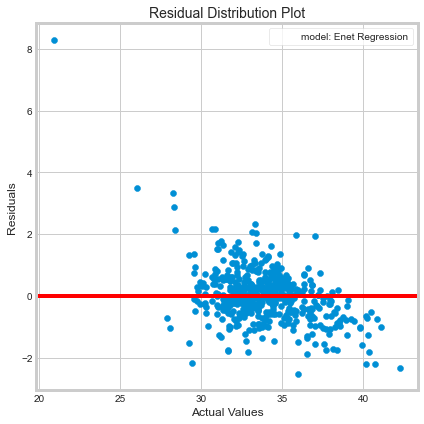

In [1140]:
# residual plot
residuals = ypred - y_test
plt.rcParams['figure.figsize'] = (6, 6)
plt.scatter(y_test, residuals)
plt.axhline(0, linestyle='-', color='r')
plt.title('Residual Distribution Plot',fontsize=14)
plt.xlabel('Actual Values',fontsize=12)
plt.ylabel('Residuals',fontsize=12)
plt.plot([], [], ' ', label="model: Enet Regression")
plt.legend()
plt.tight_layout()

Here we also see a random scatter centred around zero. 

#### Summary of Scores

In [1082]:
print("Lin Reg RMSE: ", lr_rmse_score.mean()) 
print("Lin Reg R2 score: ", lr_test_r2_score.mean())
print("-----------------------------------")
print("Ridge RMSE: ",ridge_rmse_scores.mean())
print("Ridge R2 score: ", ridge_test_r2_score.mean())
print("-----------------------------------")
print("Lasso RMSE: ",lasso_rmse_scores.mean())
print("Lasso R2 score: ", lasso_test_r2_score.mean())
print("-----------------------------------")
print("Enet RMSE: ",enet_rmse_scores.mean())
print("Enet R2 score: ", enet_test_r2_score.mean())

Lin Reg RMSE:  26104940455.075928
Lin Reg R2 score:  -5.902321224743555e+21
-----------------------------------
Ridge RMSE:  0.8367695507849179
Ridge R2 score:  0.8751689750951371
-----------------------------------
Lasso RMSE:  0.8327849036652587
Lasso R2 score:  0.8776264760054415
-----------------------------------
Enet RMSE:  0.8307639012401362
Enet R2 score:  0.876979845922186


Generally the regularized models did better, with Lasso having the highest R2 score, whereby the model would be able to account for 87% of variability of data. I will select Lasso as the production model. See [next notebook](03-model-tuning-and-recommendations.ipynb) for tuning of model, benchmarking, and recommendations.

## References

"Check Your Residual Plots to Ensure Trustworthy Regression Results!" (Frost, 2020)
https://statisticsbyjim.com/regression/check-residual-plots-regression-analysis/

"How to Configure k-Fold Cross-Validation" (Brownlee, 2020)
https://machinelearningmastery.com/how-to-configure-k-fold-cross-validation/